# Neural Networks Model using Keras and TensorFlow

## Objectives:
-Create a neural network model with Keras

-Evaluate models using cross-validation with scikit-learn 

-Tune model with Keras

In [55]:
import numpy 
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

## Dataset Visualization:

In [138]:


# load dataset 
df = pd.read_csv("DataNVMsmall.csv") 
dataset = df.values

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)


if True:
    encode_numeric_zscore(df, 'size')
    encode_numeric_zscore(df, 'canalhouse')
    encode_numeric_zscore(df, 'rooms')
    encode_numeric_zscore(df, 'balconyroofterrace')
    encode_numeric_zscore(df, 'parking')
    encode_numeric_zscore(df, 'carport')
    encode_numeric_zscore(df, 'garage')
    encode_numeric_zscore(df, 'garden')
    encode_numeric_zscore(df, 'maintenancegood')
    encode_numeric_zscore(df, 'centralheating')
    encode_numeric_zscore(df, 'insulation')
    encode_numeric_zscore(df, 'listed')
    
dataset = df.values
#split data into X and Y variables:
X = dataset[:,1:13]
Y = dataset[:,0]

print(X)
print(Y)


# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

#plot regression chart
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    






[[ 5.15761734 -0.24349167  4.21807358 ...  0.30806952  0.68210999
  -0.25360226]
 [ 5.15761734 -0.24349167  4.21807358 ...  0.30806952  0.68210999
  -0.25360226]
 [ 5.15761734 -0.24349167 -0.70732422 ...  0.30806952  0.68210999
  -0.25360226]
 ...
 [-0.86802419 -0.24349167 -2.18494357 ...  0.30806952  0.68210999
  -0.25360226]
 [-0.86802419 -0.24349167 -2.18494357 ...  0.30806952  0.68210999
   3.94122854]
 [-0.86802419 -0.24349167 -2.18494357 ... -3.24441209 -1.46531273
  -0.25360226]]
[1305000. 1250000. 1225000. ...  865000.  855000.  390000.]


In [139]:
df.head() #verifying that we could read the data correctly

,price,size,canalhouse,rooms,balconyroofterrace,parking,carport,garage,garden,maintenancegood,centralheating,insulation,listed
0,1305000,5.157617,-0.243492,4.218074,-1.141493,1.078118,-0.212208,1.365852,-1.346702,-0.723816,0.30807,0.682110,-0.253602
1,1250000,5.157617,-0.243492,4.218074,-1.141493,1.078118,-0.212208,1.365852,-1.346702,-0.723816,0.30807,0.682110,-0.253602
2,1225000,5.157617,-0.243492,-0.707324,-1.141493,1.078118,-0.212208,1.365852,-1.346702,1.380882,0.30807,0.682110,-0.253602
3,3150000,4.686864,-0.243492,1.755375,-1.141493,1.078118,-0.212208,1.365852,-1.346702,1.380882,0.30807,0.682110,-0.253602
4,2050000,4.686864,-0.243492,-0.707324,0.875611,1.078118,4.710032,-0.731781,0.742187,1.380882,0.30807,-1.465313,-0.253602


## Baseline Neural Network Model 

In [140]:

# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Baseline: -859950109551.00 (131100397091.00) MSE


In [114]:
print(Xscaled)


[[ 3.03807013 -0.4843221   1.57314861 ...  0.5         1.19959343
  -0.42008403]
 [ 3.03807013 -0.4843221   1.57314861 ...  0.5         1.19959343
  -0.42008403]
 [ 3.03807013 -0.4843221  -1.69064518 ...  0.5         1.19959343
  -0.42008403]
 ...
 [-1.0029915  -0.4843221  -0.38512767 ... -2.         -0.83361577
  -0.42008403]
 [-1.0029915   2.0647416  -0.38512767 ...  0.5        -0.83361577
   2.38047614]
 [-1.0029915  -0.4843221  -0.71150705 ...  0.5        -0.83361577
  -0.42008403]]


In [90]:
print(Y)


[1305000 1250000 1225000 3150000 2050000 1025000 2680000 2310000 2006045
 1370000 1575000  835800 3625000  612500 2100000  935000  935000 2200000
 1750000 4500000 2000000 1050000 2300000 2500000 2700000 1750000 1690000
 2320000 2415000 2000000 1470000 1331250 1050000 1737500 2300000  537500
 2300000 1250000  930000 1900000 1345000  505001 2350000 2325000 1595000
 1400000 1275000 2400000 1275000  775000 1500000 4000000 1615000 1400000
 2300000 1375000 1300000 2120000 1265000 1260000 2250000  540000 3650000
 1250000 1450000 1950000 1900000 1260040 2315000 1485000 2200000 1395000
 1600000 1200000 3000000 1350000 1175000 1250000 1050000  850000 1100000
 1378750  900000  775000 1910000 1412500 1405000 1341392 1025000  640000
 2050000 1400000 1150000 2775000 2250000 1750000 1165000  962500 1500000
 2425000]


Score (RMSE): 895954.2789140233


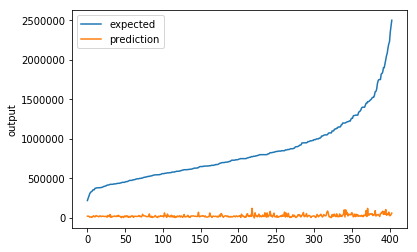

In [141]:
model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = numpy.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

In [39]:
numpy.sqrt(100)

10.0